In [1]:
pip install evidently

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 12.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 86.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82816 sha256=9153a95f0eaa329a82bb3540255d16b5d34d8ef556428cd3f3ca4e5fa0e3c96a
  Stored in directory: /root/.cache/pip/wheels/a0/e8/c6/a37ea663620bd5200ea1ba0907ab3c217042c1d035ef606acc
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55622 sha256=5a3c6ef8e25bef85f8dc840ebef79d4a2800ebbf6dd6a6878c516942aa388df2
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


# Importing Necessary libraries


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/kaggle"

In [4]:
%cd /content/drive/MyDrive/kaggle

/content/drive/MyDrive/kaggle


In [ ]:
!kaggle datasets download -d ashishpatel26/fer2018

In [ ]:
%ls

In [ ]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [ ]:
%ls

In [5]:
# imports
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from collections import defaultdict
from PIL import Image

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.utils import make_grid

from tqdm.notebook import tqdm
tqdm.pandas()

In [6]:
dataset=pd.read_csv("fer20131.csv")

In [11]:
emotions = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

  0%|          | 0/7 [00:00<?, ?it/s]

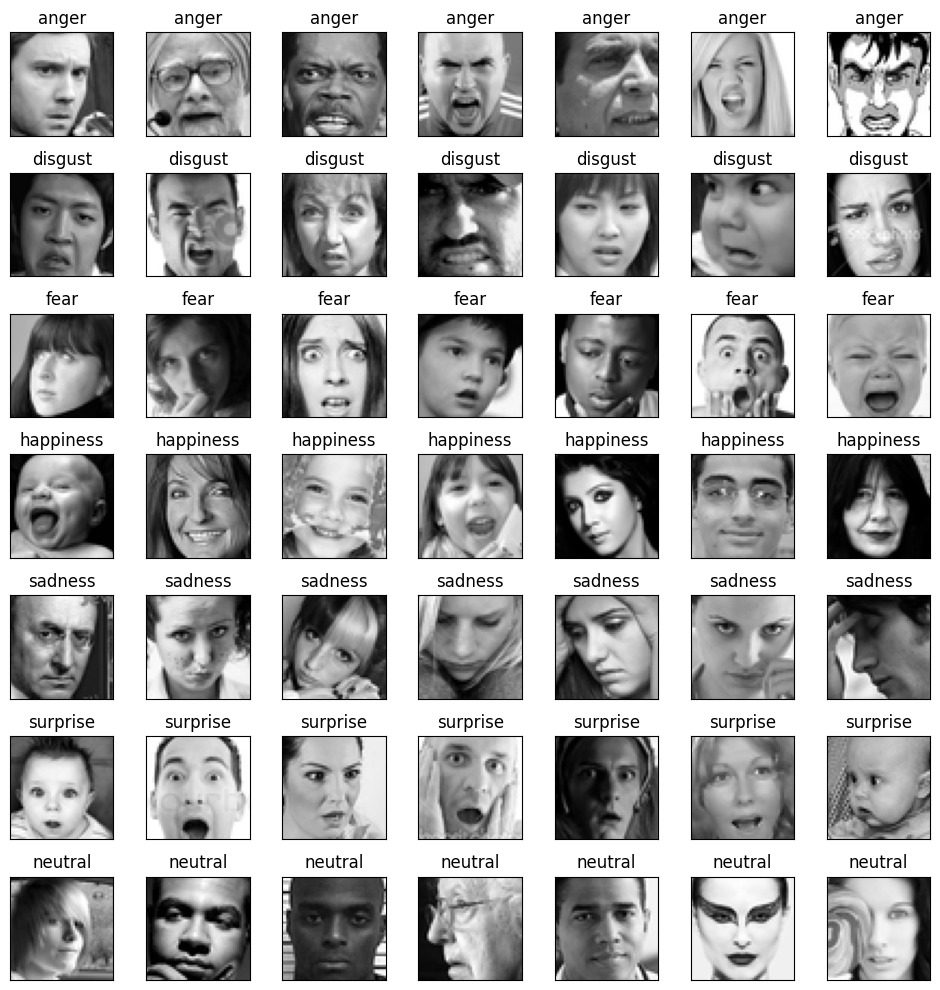

In [13]:
fig = plt.figure(1, (10, 10))

k = 0
for label in tqdm(sorted(dataset.emotion.unique())):
    for j in range(7):
        px = dataset[dataset.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap = 'gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

In [7]:
dataset["emotion"].value_counts(normalize=True)*100

3    25.048068
6    17.270878
4    16.933709
2    14.269791
0    13.801655
5    11.151671
1     1.524229
Name: emotion, dtype: float64

**Data is imbalanced so data augementation is necessary**

In [14]:
train_df = dataset[dataset["Usage"] == "Training"]
val_df = dataset[dataset["Usage"] == "PublicTest"]
test_df = dataset[dataset["Usage"] == "PrivateTest"]

## Data Transformation into tensor dataset

In [15]:
class FER2018Dataset(Dataset):
    '''
        Parse raw data to form a Dataset of (X, y).
    '''
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.classes = {0: 'Angry', 
                        1: 'Disgust', 
                        2: 'Fear', 
                        3: 'Happy', 
                        4: 'Sad', 
                        5: 'Surprise', 
                        6: 'Neutral'
                       }

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        label = int(row['emotion'])
        img = np.array(row["pixels"].split(' '), dtype=np.uint8).reshape(48, 48)
        img = np.stack([img] * 3, axis=2) # make a 3-channel RGB image from a grayscale
      

        if self.transform:
            img = self.transform(img)
        
        return {
                'image': torch.tensor(img, dtype=torch.float),
                'label': torch.tensor(label, dtype=torch.long)
            }

In [16]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip()
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = FER2018Dataset(train_df, train_transform)
val_dataset = FER2018Dataset(val_df, test_transform)
test_dataset = FER2018Dataset(test_df, test_transform)

In [17]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True, num_workers=1, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size, num_workers=1, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, num_workers=1, pin_memory=True)

# Base-Model

In [18]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(128*6*6, 1024),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 7)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        return x
model=Net()

In [38]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    model=model.cuda()
else:
    device = torch.device('cpu')

In [39]:
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    train_running_loss = 0.0
    train_running_acc = 0.0
   
    for data in tqdm(dataloader, desc="Training...", total=len(dataloader)):
        images, labels = data['image'].to(device), data['label'].to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        train_running_loss += loss.clone().detach()
        train_running_acc += accuracy(outputs.clone().detach(), labels)
        
        loss.backward()
        optimizer.step()
    
    train_loss = train_running_loss / len(dataloader)       
    train_acc = train_running_acc / len(dataloader)

    return train_loss, train_acc

In [40]:
# validation function
def validate(model, dataloader, optimizer, loss_fn):
    model.eval()
    
    valid_running_loss = 0.0
    vaild_running_acc = 0.0
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validating...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)
           
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            valid_running_loss += loss.clone().detach()
            vaild_running_acc += accuracy(outputs.clone().detach(), labels)
        
    valid_loss = valid_running_loss / len(dataloader)
    valid_acc = vaild_running_acc / len(dataloader)
    
    return valid_loss, valid_acc

In [22]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [23]:
# loss function and optimizer
epochs = 15
lr = 0.0005
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), weight_decay=5e-2, lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [24]:
# main loop
train_loss = []
val_loss = []
train_acc = []
val_acc = []

for epoch in range(1, epochs + 1):
    train_epoch_loss, train_epoch_acc = train(model, train_dataloader, optimizer, loss_function)
    val_epoch_loss, val_epoch_acc = validate(model, val_dataloader, optimizer, loss_function)
    scheduler.step(val_epoch_loss)
    
    train_loss.append(train_epoch_loss.detach().cpu().numpy())
    val_loss.append(val_epoch_loss.detach().cpu().numpy())
    train_acc.append(train_epoch_acc.detach().cpu().numpy())
    val_acc.append(val_epoch_acc.detach().cpu().numpy())
    print(f'Epoch: {epoch},\
          Train loss: {train_epoch_loss:.4f},\
          Train acc: {train_epoch_acc:.4f},\
          Val loss: {val_epoch_loss:.4f},\
          Val acc: {val_epoch_acc:.4f}\
          ')
print('DONE TRAINING')

Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 1,          Train loss: 1.6297,          Train acc: 0.3499,          Val loss: 1.3985,          Val acc: 0.4527          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 2,          Train loss: 1.3791,          Train acc: 0.4692,          Val loss: 1.2431,          Val acc: 0.5119          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 3,          Train loss: 1.2756,          Train acc: 0.5140,          Val loss: 1.1776,          Val acc: 0.5495          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 4,          Train loss: 1.2109,          Train acc: 0.5402,          Val loss: 1.1413,          Val acc: 0.5538          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 5,          Train loss: 1.1607,          Train acc: 0.5557,          Val loss: 1.1162,          Val acc: 0.5771          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 6,          Train loss: 1.1323,          Train acc: 0.5720,          Val loss: 1.1021,          Val acc: 0.5785          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 7,          Train loss: 1.0934,          Train acc: 0.5869,          Val loss: 1.0735,          Val acc: 0.5851          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 8,          Train loss: 1.0747,          Train acc: 0.5954,          Val loss: 1.0415,          Val acc: 0.5978          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 9,          Train loss: 1.0498,          Train acc: 0.6027,          Val loss: 1.0523,          Val acc: 0.6024          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 10,          Train loss: 1.0280,          Train acc: 0.6125,          Val loss: 1.0593,          Val acc: 0.5996          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 11,          Train loss: 1.0123,          Train acc: 0.6153,          Val loss: 1.0257,          Val acc: 0.6144          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 12,          Train loss: 0.9884,          Train acc: 0.6279,          Val loss: 1.0602,          Val acc: 0.6054          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 13,          Train loss: 0.9728,          Train acc: 0.6344,          Val loss: 1.0004,          Val acc: 0.6325          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 14,          Train loss: 0.9506,          Train acc: 0.6425,          Val loss: 1.0248,          Val acc: 0.6261          


Training...:   0%|          | 0/449 [00:00<?, ?it/s]

Validating...:   0%|          | 0/57 [00:00<?, ?it/s]

Epoch: 15,          Train loss: 0.9392,          Train acc: 0.6495,          Val loss: 1.0246,          Val acc: 0.6185          
DONE TRAINING


## Results

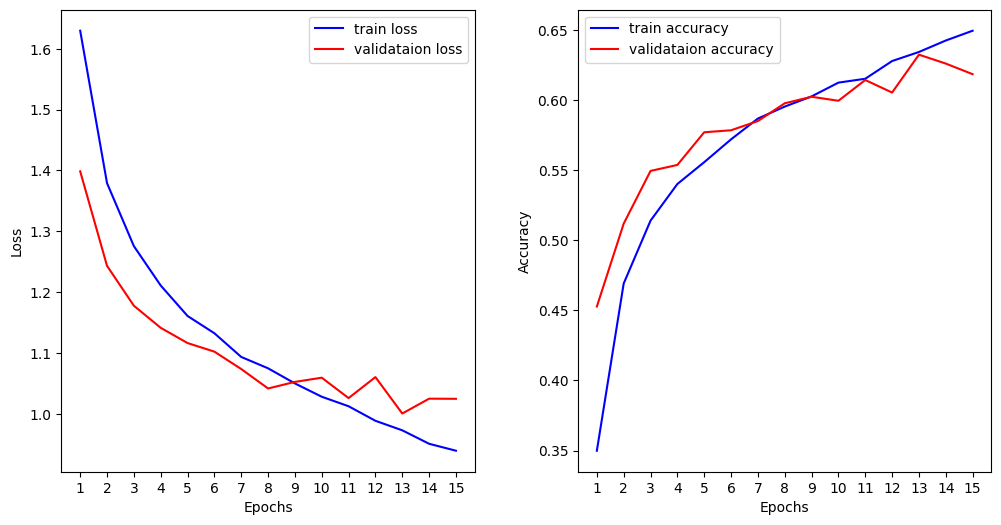

In [25]:
# loss plots
plt.figure(figsize=(12, 6))

plt.subplot(121)
plt.plot(train_loss, color='blue', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.xticks(range(epochs), range(1, epochs + 1))
plt.ylabel('Loss')
plt.legend()


# accuracy plots
plt.subplot(122)
plt.plot(train_acc, color='blue', label='train accuracy')
plt.plot(val_acc, color='red', label='validataion accuracy')
plt.xlabel('Epochs')
plt.xticks(range(epochs), range(1, epochs + 1))
plt.ylabel('Accuracy')
plt.legend()
plt.subplots_adjust(wspace=0.25)
plt.show()

In [26]:
classes = list(test_dataset.classes.values())

# test function
def test(model, dataloader):
    model.eval()
    
    # prepare to count predictions for each class
    correct_pred = defaultdict(int)
    total_pred = defaultdict(int)
    
    all_labels = []
    all_predictions = []
    
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Testing...", total=len(dataloader)):
            images, labels = data['image'].to(device), data['label'].to(device)
           
            outputs = model(images)
            
            _, predictions = torch.max(outputs, 1)
            predictions = predictions.cpu().detach().numpy()
            labels = labels.cpu().detach().numpy()
            all_labels.extend(labels)
            all_predictions.extend(predictions)
            
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    return correct_pred, total_pred, all_labels, all_predictions

correct_pred, total_pred, all_labels, all_predictions = test(model, test_dataloader)

Testing...:   0%|          | 0/57 [00:00<?, ?it/s]

In [27]:
# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.4f}')

total_acc = sum(correct_pred[class_name] for class_name in classes) / len(test_dataset)
print(f"Total accuracy: {total_acc:.4f}")

Accuracy for class: Angry is 0.4725
Accuracy for class: Neutral is 0.7300
Accuracy for class: Happy is 0.8828
Accuracy for class: Sad   is 0.5438
Accuracy for class: Surprise is 0.7620
Accuracy for class: Fear  is 0.2178
Accuracy for class: Disgust is 0.3636
Total accuracy: 0.6241


## Data monitoring

In [28]:
try:
    import evidently
except:
    !pip install git+https://github.com/evidentlyai/evidently.git

In [29]:
from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset, RegressionTestPreset
from evidently.tests import *

In [30]:
test_df.rename(columns={"emotion":"target"},inplace=True)

In [31]:
test_df["prediction"]=all_predictions

In [32]:
from evidently import ColumnMapping

column_mapping = ColumnMapping()

column_mapping.target = test_df["target"]
column_mapping.prediction = test_df["prediction"]

In [33]:
ref_data_sample = test_df[:1500]
prod_data_sample = test_df[1500:]

In [34]:
#probabilistic binary classification
classification_report = Report(metrics=[
    ClassificationQualityMetric(),
    ClassificationClassBalance(),
    ConflictTargetMetric(),
    ConflictPredictionMetric(),
    ClassificationConfusionMatrix(),
    ClassificationQualityByClass(),
    ClassificationProbDistribution(),

  
    
])

classification_report.run(reference_data=ref_data_sample, current_data=prod_data_sample)
classification_report